# MNIST Classifier: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Importing, Augmenting and Splitting the dataset:

`keras.datasets` has numpy arrays but these have each RGB values, which lie between 0 and 255.   

* The usual matrix representation has each pixel with a value between 0 and 1, with 0 being white and 1 being black, and to get this we divide by 255.

* I've split the training set into 2 parts of 30k images and performed the following augmentations:
    - Adding random noise 
    - Shifting the images by 20%
    - Rotated images randomly between 10 and -10 degrees
    - Flipped images laterally, with a 50% chance.

In [2]:

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


y_train_encoded = np.array(pd.get_dummies(y_train, dtype=int))
y_test_encoded = np.array(pd.get_dummies(y_test, dtype=int))


x_dev, x_test, y_dev, y_test = train_test_split(x_test, y_test_encoded, test_size=0.5, random_state=23)


seq1 = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=0.05*255),
    iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
])

seq2 = iaa.Sequential([
    iaa.Affine(rotate=(-10, 10)),
    iaa.Fliplr(0.50)
])


x_train_sub_1 = seq1.augment_images(x_train[:30000])
x_train_sub_2 = seq2.augment_images(x_train[30000:])


x_train_mod = np.concatenate((x_train_sub_1, x_train_sub_2), axis=0) / 255.0
y_train_mod = np.concatenate((y_train_encoded[:30000], y_train_encoded[:30000]), axis=0).T


x_train_mod = x_train_mod.reshape(-1, 28*28).T


x_train = x_train.astype('float') / 255.0
x_dev = x_dev.astype('float') / 255.0
x_test = x_test.astype('float') / 255.0


x_train = x_train.reshape(-1, 28*28).T


x_train = np.concatenate((x_train, x_train_mod), axis=1)
y_train = np.concatenate((y_train_encoded.T, y_train_mod), axis=1)

y_dev=y_dev.T
y_test=y_test.T


print("Shapes of datasets:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_dev:", x_dev.shape)
print("y_dev:", y_dev.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

Shapes of datasets:
x_train: (784, 120000)
y_train: (10, 120000)
x_dev: (5000, 28, 28)
y_dev: (10, 5000)
x_test: (5000, 28, 28)
y_test: (10, 5000)


In [3]:
print(x_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [4]:
print(y_train)

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [5]:
print(y_test)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 1]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


In [6]:
print(y_dev)

[[0 0 0 ... 1 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


### Activation functions and gradients

In [7]:
def activation_function(z,str):
    if str=="relu":
        return np.maximum(z,0)
    elif str=="tanh":
        return np.tanh(z)
    elif str=="softmax":
        return(np.exp(z))/np.sum(np.exp(z),axis=0,keepdims=True)

def tanh_grad(z):
    return (1-np.power(np.tanh(z),2))

def relu_grad(z):
    return np.array(z>0,dtype=np.float32)

### Initialising Parameters:
We have:
* 1 input layer
* 2 hidden layers
* 1 output layer

In [8]:
def random_initialization(l_o,l_i):
    return np.random.randn(l_o,l_i)*0.01

def glorot_initialization(l_o, l_i):
    return np.random.randn(l_o, l_i) * np.sqrt(1 / l_i)

def he_initialization(l_o,l_i):
    return np.random.randn(l_o, l_i) * np.sqrt(2 / l_i)


In [9]:
def init_params(layer_dims):
    params = {}
    
    for l in range(1, len(layer_dims)):
        W = he_initialization(layer_dims[l],layer_dims[l-1])
        B = np.zeros((layer_dims[l], 1))
        params["W" + str(l)] = W
        params["B" + str(l)] = B
        
    return params

### Cost Function: (Average Cross-Entropy Loss)

In [10]:
def cost_function(y_hat, y):
 return -(1/y.shape[1])*(np.sum(y*np.log(y_hat)))
 


### Forward and Backward Propagations:

In [11]:
def forward_prop(x, params):
    cache = {}
    A = x  
   
    for l in range(1, 4): 
        
        W = params["W" + str(l)]
        B = params["B" + str(l)]
        
        Z = np.dot(W, A) + B
        
        if l == 1:
            A=activation_function(Z,"relu")
        elif l == 2:
            A=activation_function(Z,"tanh")
        else:
            A=activation_function(Z,"softmax")
        
        
        cache["Z" + str(l)] = Z
        cache["A" + str(l)] = A
    
    return cache

In [12]:
def back_prop(x, y, cache, params):
    
    W3 = params['W3']
    W2 = params['W2']
    
    A1 = cache['A1']
    A2 = cache['A2']
    A3 = cache['A3']
    
    m = x.shape[1]
    
    dZ3 = (A3 - y)
    dW3 = (1/m)*np.dot(dZ3, A2.T)
    dB3 = (1/m)*np.sum(dZ3, axis = 1, keepdims = True)
    
    dZ2 = (1/m)*np.dot(W3.T, dZ3)*tanh_grad(A2)
    dW2 = (1/m)*np.dot(dZ2, A1.T)
    dB2 = (1/m)*np.sum(dZ2, axis = 1, keepdims = True)

    dZ1 = (1/m)*np.dot(W2.T, dZ2)*relu_grad(A1)
    dW1 = (1/m)*np.dot(dZ1, x.T)
    dB1 = (1/m)*np.sum(dZ1, axis = 1, keepdims = True)
    
    grads = {
        "dW1" : dW1,
        "dB1" : dB1,
        "dW2" : dW2,
        "dB2" : dB2,
        "dW3" : dW3,
        "dB3" : dB3
    }
    
    return grads


### Gradient Descent:

In [13]:
def grad_desc(alpha, params, grads):

    for l in range(1, 4):
        W = params["W" + str(l)]
        b = params["B" + str(l)]
        
        dW = grads["dW" + str(l)]
        db = grads["dB" + str(l)]
        
        # Update parameters using gradient descent
        W -= alpha * dW
        b -= alpha * db
        
        # Update params dictionary
        params["W" + str(l)] = W
        params["B" + str(l)] = b

    return params



In [14]:
def NN(x,y,layer_dims,alpha,iterations):
    
    params=init_params(layer_dims)
    cost_val=[0]*iterations

    for i in range(iterations):
        
        cache=forward_prop(x,params)
        
        #add to cost values list 
        cost_val[i]=cost_function(cache['A3'],y)
        
        #perform backprop, find gradients
        grads=back_prop(x,y,cache,params)
        
        #update parameters
        params=grad_desc(alpha,params,grads)
        
        
        print(f"The cost at iteration {i} is: {cost_val[i]}")        
    
    return params,cost_val


In [15]:
L1=784
L2=784
layer_dims=[x_train.shape[0],L1,L2,y_train.shape[0]]


params,cost_values=NN(x_train,y_train,layer_dims,0.2,350)

The cost at iteration 0 is: 2.423754126746061
The cost at iteration 1 is: 2.275683020622694
The cost at iteration 2 is: 2.1851704350466203
The cost at iteration 3 is: 2.1189123883285017
The cost at iteration 4 is: 2.06039095569793
The cost at iteration 5 is: 2.0086655427155247
The cost at iteration 6 is: 1.9629465493712066
The cost at iteration 7 is: 1.9225133385145745
The cost at iteration 8 is: 1.8867071130327002
The cost at iteration 9 is: 1.8549372581899557
The cost at iteration 10 is: 1.8266810471613635
The cost at iteration 11 is: 1.8014808722989288
The cost at iteration 12 is: 1.778939033301322
The cost at iteration 13 is: 1.7587116415607082
The cost at iteration 14 is: 1.7405022679714321
The cost at iteration 15 is: 1.724055825320036
The cost at iteration 16 is: 1.7091529272828647
The cost at iteration 17 is: 1.695604836023703
The cost at iteration 18 is: 1.683249025146906
The cost at iteration 19 is: 1.671945335207836
The cost at iteration 20 is: 1.6615726737069458
The cost at

### Predictions:

In [16]:
def y_hat_func(x,params):
    
    cache=forward_prop(x,params)

    y_hat=cache['A3']
    y_hat=np.argmax(y_hat,0)    
    
    return y_hat

### Scores:

In [17]:
x_test=x_test.reshape(5000,-1).T
x_dev=x_dev.reshape(5000,-1).T

y_hat_dev=y_hat_func(x_dev,params)
y_hat_test=y_hat_func(x_test,params)

print(f"\n\nDev Accuracy Score: {accuracy_score(np.argmax(y_dev,0),y_hat_dev)*100}%")
print(f"Dev Precision Score:{precision_score(np.argmax(y_dev,0),y_hat_dev,average='weighted')*100}% ")
print(f"Dev Recall Score:{recall_score(np.argmax(y_dev,0),y_hat_dev,average='weighted')*100}")
print(f"Dev f1 Score:{f1_score(np.argmax(y_dev,0),y_hat_dev,average='weighted')*100}")

print(f"\n\nTest Accuracy Score: {accuracy_score(np.argmax(y_test,0),y_hat_test)*100}%")
print(f"Test Precision Score:{precision_score(np.argmax(y_test,0),y_hat_test,average='weighted')*100}% ")
print(f"Test Recall Score:{recall_score(np.argmax(y_test,0),y_hat_test,average='weighted')*100}")
print(f"Test f1 Score:{f1_score(np.argmax(y_test,0),y_hat_test,average='weighted')*100}")




Dev Accuracy Score: 90.32%
Dev Precision Score:90.37132589351639% 
Dev Recall Score:90.32
Dev f1 Score:90.25941640636742


Test Accuracy Score: 90.62%
Test Precision Score:90.63128007476033% 
Test Recall Score:90.62
Test f1 Score:90.56712978642929


### Cost Plot:

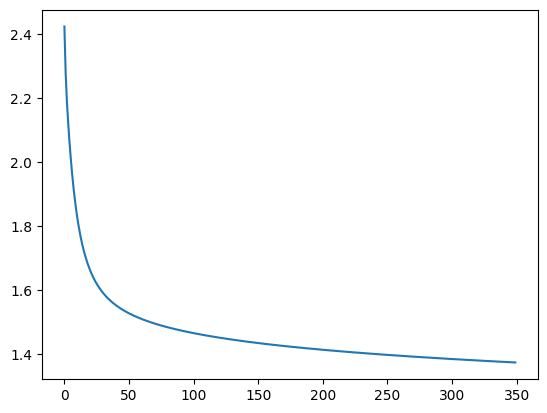

In [18]:
plt.plot(cost_values)